## План работы

[1. Подготовка данных](#1.)<br>
[1.1. Откроем данные и изучим их](#1.1.)<br>
[1.2. Проведем предобработку данных](#1.2.)<br>
[2. Обучение моделей](#2.)<br>
[3. Анализ моделей](#3.)<br>

# 1. Подготовка данных <a id = "1."> </a>

## 1.1. Откроем данные и изучим их <a id = "1.1."> </a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import lightgbm as lgb
from catboost import Pool, CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

warnings.filterwarnings('ignore') 
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100
%matplotlib inline

autos = pd.read_csv(r'E:\Документы прочие\IT\Яндекс практикум\Project\9 Численные методы\autos.csv', index_col=[0])


def data_info(data):
    '''
    Функция принимает в качестве аргументов датасет.
    Функция выводит информацию о датасете и первые 10 строк датасета, а также количество дубликатов.
    '''
    data.info()
    display(data.head(10))
    print('Количество дубликатов в данных:', data.duplicated().sum())
    
def data_values(data, c):
    '''
    Функция принимает в качестве аргументов: датасет, колонку датасета.
    Функция выводит информацию о количестве значений в колонке, а также о количестве пропусков.
    '''
    display(data[c].value_counts())
    print('Количество пропусков в колонке:', data[c].isnull().sum())
    
def hist(data, c, t, b):
    '''
    Функция принимает в качестве аргументов: датасет, колонку датасета, название гистрограммы, количество корзин.
    Функция выводит гистрограмму.
    '''
    plt.figure(figsize=(15, 10))
    plt.title(t, fontsize=15)
    sns.distplot(data[c], bins=b, kde=True)

def box_plt(data, c, t):
    '''
    Функция принимает в качестве аргументов: датасет, колонку датасета, название диаграммы.
    Функция выводит диаграмму ящик с усами.
    '''
    plt.figure(figsize=(15,10))
    sns.boxplot(data = data[c])
    plt.title(t, fontsize=15)
    plt.grid(True)
    plt.show()
    
def min_max(data, c):
    '''
    Функция принимает в качестве аргументов: датасет, колонку датасета.
    Функция выводит минимальное и максимальное значение.
    '''
    print('Min:', data[c].min())
    print('Max:', data[c].max())

Мы будем использовать датасет autos, который содержит технические характеристики, комплектации и цены автомобилей.

In [2]:
data_info(autos)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


Количество дубликатов в данных: 4


Датасет autos размером в 354369 строк содержит 16 колонок и содержит данные 2-х типов: int64, object. В датасете присутствует 4 дубликата. Дубликаты могут присутствовать из-за ошибки при экспорте данных.

In [3]:
display(autos.isnull().sum())

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Также в датасете присутствуют пропуски в 5 колонках: VehicleType, Gearbox, Model, FuelType, NotRepaired. Вероятно пропуски связаны с ошибкой при сборе данных, а также с тем, что перед продажей заполнялись не все признаки автомобилей.

### Описание данных в датасете:

#### Признаки
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя


#### Целевой признак
- Price — цена (евро)

### Вывод

Была изучена общая информация о полученных данных. В данных присутствуют пропуски и дубликаты, который необходимо будет обработать перед обучением модели.

### 1.2. Проведем предобработку данных <a id = "1.2."> </a>

Очистим дынные от 4 дубликатов, найденных ранее.

In [4]:
autos = autos.drop_duplicates().reset_index(drop=True)

#### Очистим дынные от избыточных признаков

Проанализируем значения дат в таблице.

In [5]:
autos['DateCrawled']= pd.to_datetime(autos['DateCrawled'], format='%Y-%m-%d %H:%M:%S')
min_max(autos, 'DateCrawled')

Min: 2016-03-05 14:06:22
Max: 2016-04-07 14:36:58


In [6]:
autos['DateCreated']= pd.to_datetime(autos['DateCreated'], format='%Y-%m-%d %H:%M:%S')
min_max(autos, 'DateCreated')

Min: 2014-03-10 00:00:00
Max: 2016-04-07 00:00:00


In [7]:
autos['LastSeen']= pd.to_datetime(autos['LastSeen'], format='%Y-%m-%d %H:%M:%S')
min_max(autos, 'LastSeen')

Min: 2016-03-05 14:15:08
Max: 2016-04-07 14:58:51


В таблице представлены данные за 2014-2016 год. Колонки DateCrawled, RegistrationMonth, DateCreated, PostalCode, LastSeen содержат избыточную информацию о почтовых кодах, месяцах регистрации, датах создания и скачивания анкет и последней активности пользователя. Оставим для обучения и тестирования только те признаки, которые по нашему мнению могут влиять на цену автомобиля. Остальные признаки отбросим, чтобы не исказить обучение моделей. Признак LastSeen нам интересен, так как он показывает последнюю активность пользователя. Можно сделать вывод о том, что пользователь после продажи зашел на сайт, чтобы снять объявление, для того, чтобы его больше не беспокоили покупатели. Так как информация колонки ограничена 2016 годом, можем в дальнейшем посчитать возраст авто вычтя из 2016 года RegistrationYear.

In [8]:
autos = autos.drop(['DateCrawled', 'RegistrationMonth', 'DateCreated', 'LastSeen', 'PostalCode'], axis = 1)

#### Проанализируем значения оставшихся признаков подробнее

При анализе значений в качестве ориентира будем использовать сайт по продаже автомобилей АВИТО.

#### 1. Price

In [9]:
data_values(autos, 'Price')

0        10772
500       5670
1500      5394
1000      4648
1200      4594
         ...  
13440        1
1414         1
8069         1
10370        1
384          1
Name: Price, Length: 3731, dtype: int64

Количество пропусков в колонке: 0


Колонка Price содержит данные о цене автомобиля. 

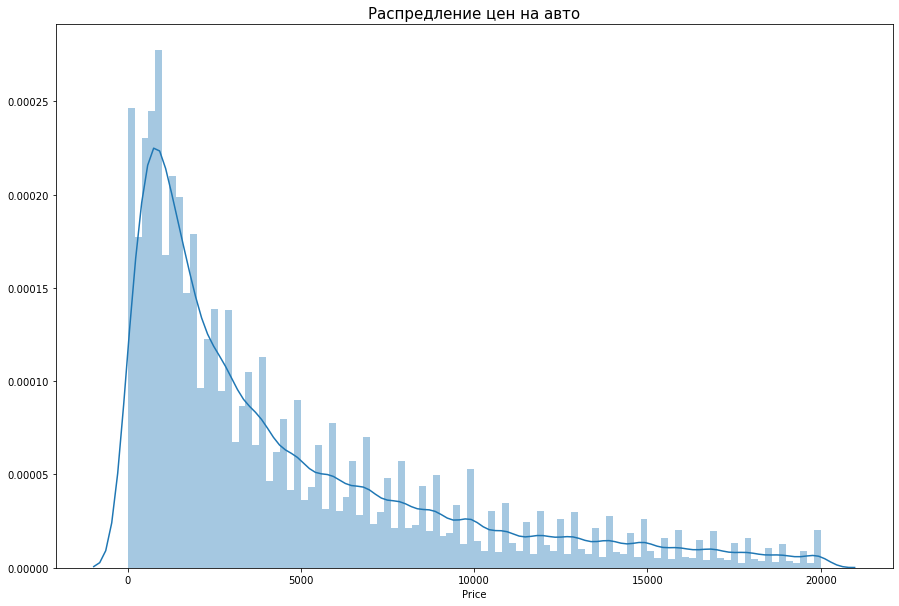

In [10]:
hist(autos, 'Price', 'Распредление цен на авто', 100)

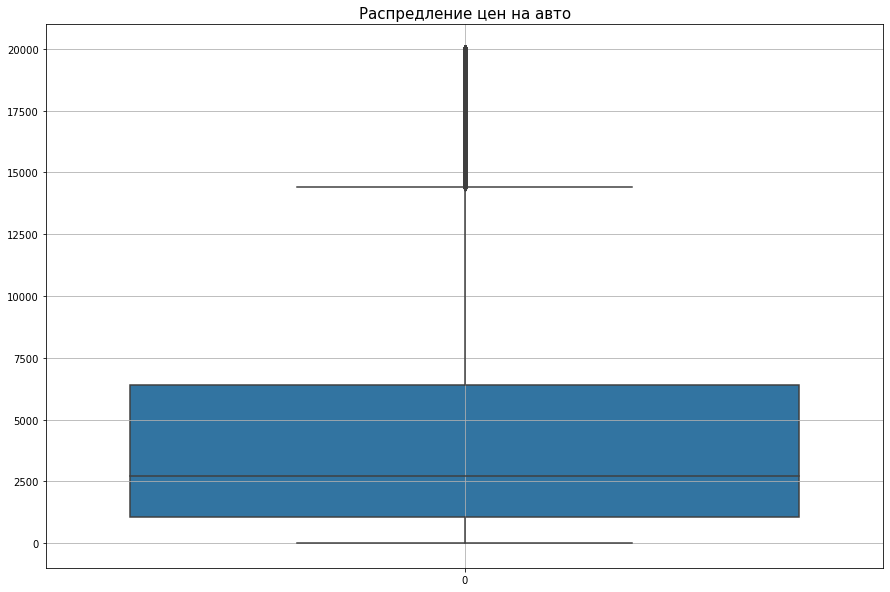

In [11]:
box_plt(autos, 'Price', 'Распредление цен на авто')

In [12]:
display(autos.query('Price < 300'))

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired,NumberOfPictures
7,0,sedan,1980,manual,50,other,40000,petrol,volkswagen,no,0
32,245,sedan,1994,NaN,0,golf,150000,petrol,volkswagen,no,0
40,0,NaN,1990,NaN,0,corsa,150000,petrol,opel,NaN,0
59,1,suv,1994,manual,286,NaN,150000,NaN,sonstige_autos,NaN,0
60,200,coupe,1995,manual,102,3er,150000,petrol,bmw,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...
354269,150,small,1993,manual,55,astra,150000,petrol,opel,yes,0
354273,0,small,1999,manual,37,arosa,150000,petrol,seat,yes,0
354305,99,small,1999,manual,60,arosa,150000,petrol,seat,yes,0
354334,180,NaN,1995,NaN,0,NaN,125000,petrol,opel,NaN,0


В колонке отсутствуют пропуски, но есть нулевые и аномально низкие значения. Это может быть связано с тем, что автомобили находились в сломанном состоянии и не подлежали восстановлению, либо продавец хотел торговаться и не выставлял цену, либо от автомобиля продавался например один кузов. В любом случае нам необходимо избавиться от аномально низких значений, в том числе нулевых, так в дальнейшем они внесут неясность при обучении нашей модели и она покажет слабую точность. Мы убудились в этом проанализировав данные сайта АВИТО, можно сделать вывод о том, что автомобили дешевле 300 евро - "автохлам", который к тому же в разбитом или не рабочем состоянии. Уберем из данных автомобили, которые дешевле 300 евро, в том числе и с нулевой стоимостью, так как их невозможно восстановить.

In [13]:
autos = autos.query('Price >= 300').reset_index(drop=True)

#### 2. VehicleType

In [14]:
data_values(autos, 'VehicleType')

sedan          87687
small          73249
wagon          62528
bus            28125
convertible    19727
coupe          15279
suv            11743
other           2929
Name: VehicleType, dtype: int64

Количество пропусков в колонке: 29935


Колонка VehicleType содержит данные о типе автомобильного кузова. В колонке содержатся пропуски. Пропуски вероятно связаны с тем, что продавцы не указывали тип кузова перед продажей или данные были утеряны при экспорте. Пропуски можно заполнить наиболее часто встречающимися значениями по марке и моделе автомобиля, так как тип кузова конкретной модели редко меняется через поколония. Все, что не смогли заполнить отнесем к типу unknown.

In [15]:
autos['VehicleType'] = (
    autos.groupby(['Brand', 'Model'])['VehicleType']
    .apply(lambda x: x.fillna(x.mode()[0])))
autos['VehicleType'] = autos['VehicleType'].fillna('unknown')

#### 3. RegistrationYear and Age

In [16]:
data_values(autos, 'RegistrationYear')

2000    21357
2005    21222
1999    20978
2006    19634
2003    19406
        ...  
1931        1
1927        1
1925        1
3200        1
4100        1
Name: RegistrationYear, Length: 134, dtype: int64

Количество пропусков в колонке: 0


Колонка RegistrationYear содержит данные о годе регистрации автомобиля. Колонка не содержит пропуски, но неоторые даты регистрации не похожи на возможные. Предполагаем, что это связано с ошибкой экспорта данных. Год регистрации автомобиля не может быть позже, чем год последней активности пользователя, поэтому ограничим значения от 1960 (возраст самых старых автомобилей на АВИТО) до 2016 (год последней активности пользователей). 

In [17]:
autos = autos.query('(RegistrationYear >= 1960) & (RegistrationYear <= 2016)').reset_index(drop=True)

Создадим новый признак AGE, который будет содержать информацию о возрасте автомобиля на момент продажи.

In [18]:
autos['Age'] = 2016 - autos['RegistrationYear']

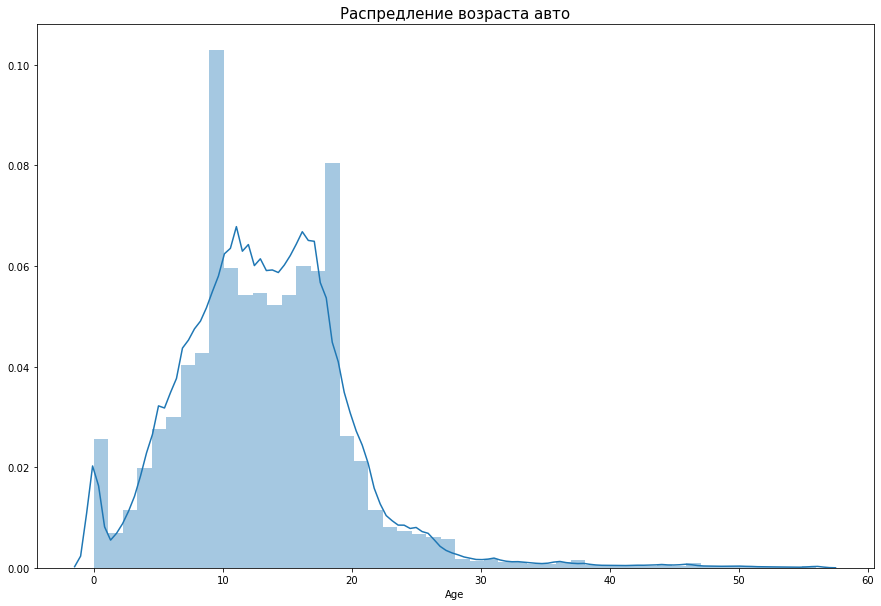

In [19]:
hist(autos, 'Age', 'Распредление возраста авто', 50)

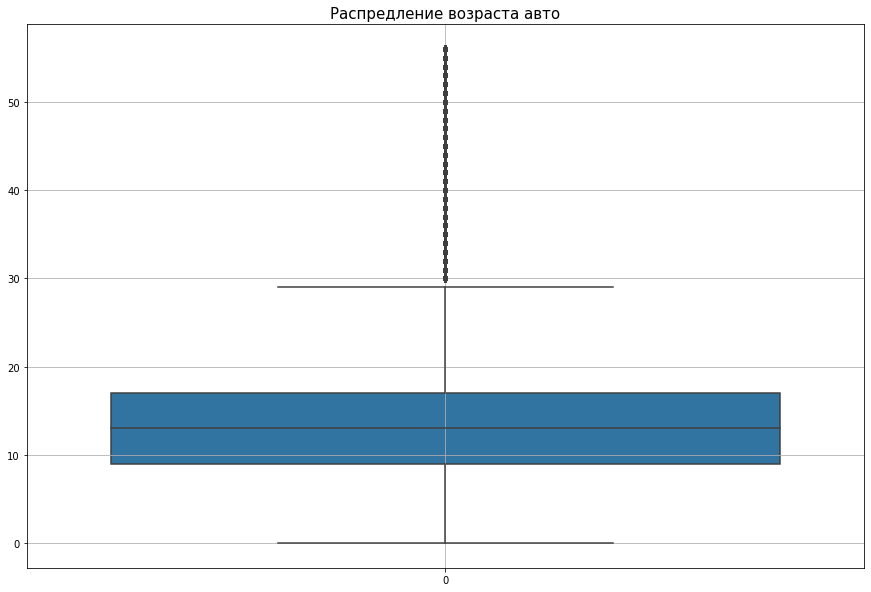

In [20]:
box_plt(autos, 'Age', 'Распредление возраста авто')

Распределение имеет вид нормального распределения, смещенного влево. Чаще ввсего продаются автомобили возрастом в 10 лет. Содержаться выбросы - автомобили, которые были старше 30 лет на момент продажи. Такие автомобили либо также являются "автохламом", либо прошли реставрацию и представляют особую ценность, которую нельзя предсказать. Очистим машины старше 30 лет. Далее колонка RegistrationYear нам не понадобится, удалим признак.

In [21]:
autos = autos.query('Age < 30').reset_index(drop=True)
autos = autos.drop(['RegistrationYear'], axis = 1)

#### 4. Gearbox

In [22]:
data_values(autos, 'Gearbox')

manual    238435
auto       61118
Name: Gearbox, dtype: int64

Количество пропусков в колонке: 12294


Колонка Gearbox содержит данные о типе коробки передач. Это категориальный признак, который необходимо будет закодировать перед обучением модели. Колонка содержит пропуски. Восстановить их не получится, так как каждая модель автомобиля может иметь как комплектации с ручной коробкой, так и с автоматической. Те коробки передач, которые не удалось установить отнесем к типу unknown.

In [23]:
autos['Gearbox'] = autos['Gearbox'].fillna('unknown')

#### 5. Power

In [24]:
data_values(autos, 'Power')

0       27243
75      20851
150     13560
60      13274
140     12252
        ...  
6012        1
1151        1
3454        1
640         1
6512        1
Name: Power, Length: 664, dtype: int64

Количество пропусков в колонке: 0


Колонка Power содержит данные о мощности (л.с.) автомобиля. Колонка не содержит пропуски, но содержит выбросы с очень большой и очень маленькой (нулевой) мощность автомобиля. Причиной выбросов может быть ошибка, возникшая при эспорте данных или ошибка пользователя, который указал очень маленькое или очень большое значение. Нулевые мощности могут быть из-за того, что продавец не вносил этих данных перед публикацией объявления. Проанализируем распределения значений.

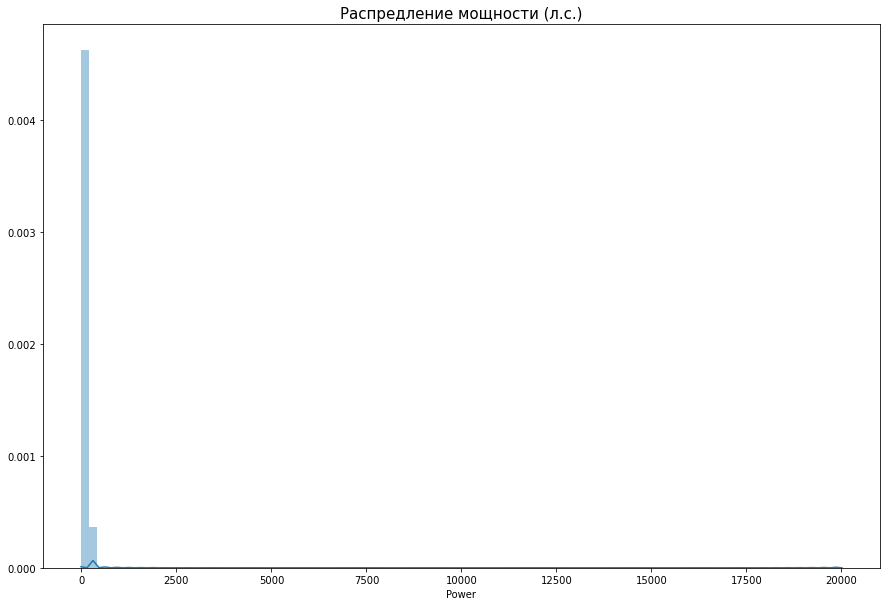

In [25]:
hist(autos, 'Power', 'Распредление мощности (л.с.)', 100)

Преобразуем нулевые значения в медианные значения по марке и моделе.

In [26]:
autos['Power'] = autos['Power'].replace(0, np.nan)
autos['Power'] = autos['Power'].fillna(autos.groupby(['Brand', 'Model'])['Power'].transform('median'))

Уберем автомобили с мощностью большей 605 л.с. (самый мощный автомобиль на АВИТО) и меньшей 23 л.с. (самый маломощный автомобиль на АВИТО).

In [27]:
autos = autos.query('(Power >= 23)&(Power <= 605) ')

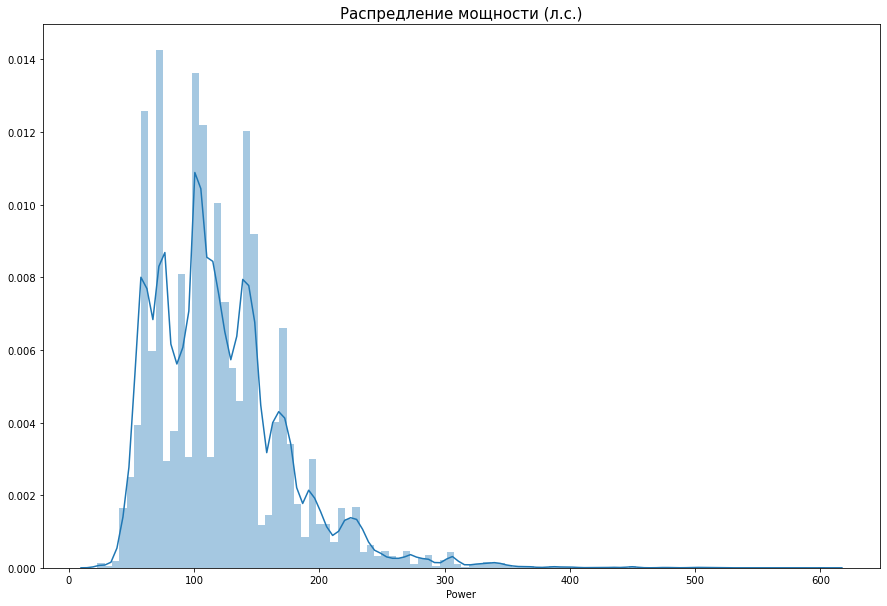

In [28]:
hist(autos, 'Power', 'Распредление мощности (л.с.)', 100)

#### 6. Model

In [29]:
data_values(autos, 'Model')

golf                  25470
other                 19970
3er                   18226
polo                  10967
corsa                 10354
                      ...  
i3                        7
kalina                    6
elefantino                4
rangerover                3
range_rover_evoque        2
Name: Model, Length: 247, dtype: int64

Количество пропусков в колонке: 9667


Колонка Model содержит данные о моделе автомобиля. Колонка содержит пропуски. Это категориальный признак, который необходимо будет закодировать перед обучением модели.  Те модели, которые не удалось установить отнесем к типу unknown.

In [30]:
autos['Model'] = autos['Model'].fillna('unknown')

#### 7. Kilometer

In [31]:
data_values(autos, 'Kilometer')

150000    206662
125000     32860
100000     12924
90000      10497
80000       9116
70000       7856
60000       6864
50000       5655
40000       4504
30000       3895
20000       3251
5000        3102
10000        865
Name: Kilometer, dtype: int64

Количество пропусков в колонке: 0


Колонка Kilometer содержит данные о пробеге автомобиля. Колонка не содержит пропусков.

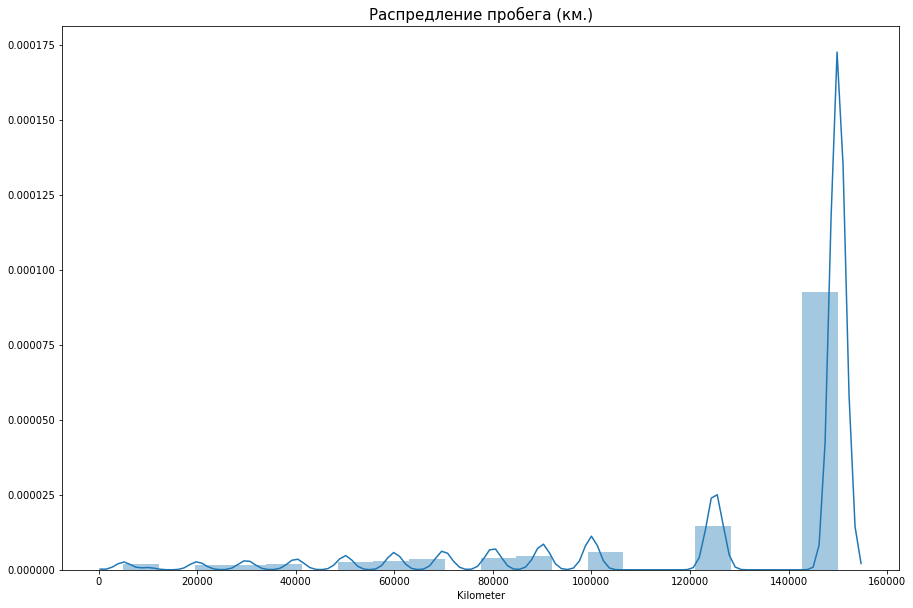

In [32]:
hist(autos, 'Kilometer', 'Распредление пробега (км.)', 20)

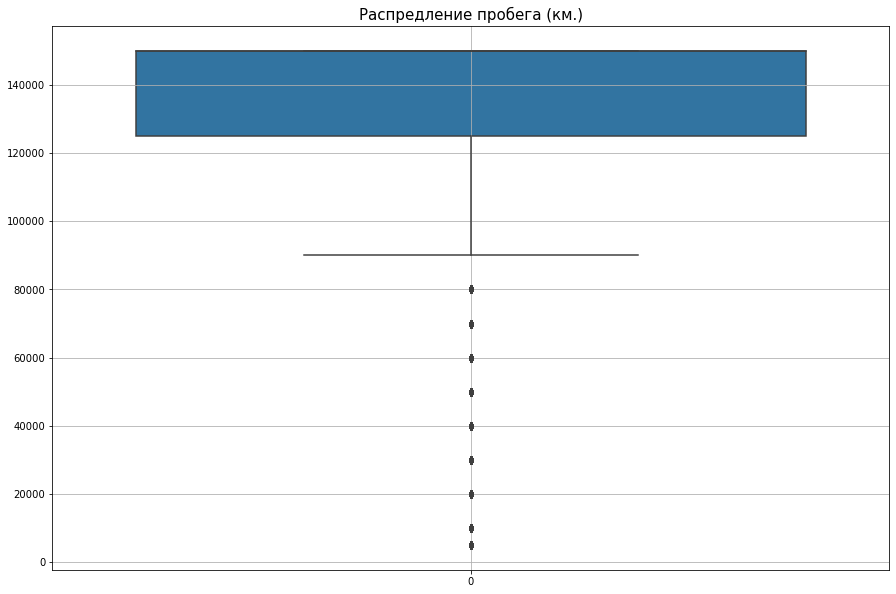

In [33]:
box_plt(autos, 'Kilometer', 'Распредление пробега (км.)')

Наибольшее количество автомобилей было продано с пробегом 150 тыс. км. Оставим колонку без изменений.

#### 8. FuelType

In [34]:
data_values(autos, 'FuelType')

petrol      190800
gasoline     93239
lpg           4891
cng            515
hybrid         218
other           86
electric        40
Name: FuelType, dtype: int64

Количество пропусков в колонке: 18262


Колонка FuelType содержит данные о типе топлива. Это категориальный признак, который необходимо будет закодировать перед обучением модели. Колонка содержит пропуски, которые возникли либо в результате ошибки при экспорте данных, либо потому что продавец в объясвлении не указывал тип топлива. Пропуски можно заполнить наиболее часто встречающимися значениями по марке и моделе автомобиля. Все что не удалось заполнить отнесем к типу unknown.

In [35]:
autos['FuelType'] = (
    autos.groupby(['Brand', 'Model'])['FuelType']
    .apply(lambda x: x.fillna(x.mode()[0])))
autos['FuelType'] = autos['FuelType'].fillna('unknown')

#### 9. Brand

In [36]:
data_values(autos, 'Brand')

volkswagen        66442
bmw               33577
opel              33507
mercedes_benz     28843
audi              26877
ford              21171
renault           15029
peugeot            9834
fiat               7908
seat               6060
skoda              5193
mazda              4978
smart              4862
citroen            4432
nissan             4320
toyota             4304
hyundai            3295
mini               3024
volvo              2893
mitsubishi         2625
honda              2491
kia                2246
suzuki             2030
alfa_romeo         1971
chevrolet          1472
chrysler           1249
sonstige_autos     1154
dacia               857
subaru              654
daihatsu            645
jeep                588
porsche             546
land_rover          487
saab                475
jaguar              445
daewoo              443
rover               374
lancia              372
trabant             209
lada                169
Name: Brand, dtype: int64

Количество пропусков в колонке: 0


Колонка Brand содержит данные о бренде автомобиля. Это категориальный признак, который необходимо будет закодировать перед обучением модели. Колонка не содержит пропусков.

#### 10. NotRepaired

In [37]:
data_values(autos, 'NotRepaired')

no     229579
yes     28211
Name: NotRepaired, dtype: int64

Количество пропусков в колонке: 50261


Колонка NotRepaired содержит данные о том был ли автомобиль в ремонте. Это категориальный признак, который необходимо будет закодировать перед обучением модели. Колонка содержит пропуски, которые возникли либо в результате ошибки при экспорте данных, либо продавец решил не указывать данную информацию в объявлении. Был ли автомобиль в ремонте или нет - очень важная информация в рамках ценообразования.  Нет возможности восстановить пропуски из исходных данных. Заполним их значением unknown.

In [38]:
autos['NotRepaired'] = autos['NotRepaired'].fillna('unknown')

#### 11. NumberOfPictures

In [39]:
data_values(autos, 'NumberOfPictures')

0    308051
Name: NumberOfPictures, dtype: int64

Количество пропусков в колонке: 0


Колонка VehicleType содержит данные о количестве фотографий автомобиля. У всех автомобилей отсутствуют фотографии. Эта колонка также не повлияет на модель, удалим ее из датасета.

In [40]:
autos = autos.drop(['NumberOfPictures'], axis = 1)

#### Веделим из данных обучающую и тестовую выборку

Для дальнейшего тестирования моделей мы выделим из данных тестовую выборку в размере 25% от всех данных.

In [41]:
autos_train, autos_test = train_test_split(autos, test_size = .25, random_state = 42)

#### Закодируем категориальные признаки и масштабируем количественные

Преобразованные данные содержат категориальные признаки VehicleType, Gearbox, Model, FuelType, Brand, NotRepaired, которые необходимо закодировать для дальнейшего обучения модели. Для этого используем технику кодирования OrdinalEncoder на данных у которых больше 3 категорий и One-Hot Encoding на данных у которых не болee 3-х категорий.

In [42]:
category_oe = ['VehicleType','Model', 'FuelType', 'Brand']
category_ohe = ['Gearbox', 'NotRepaired']
encoder = OrdinalEncoder()
encoder.fit(autos[category_oe])
# закодируем обучающую выборку
autos_train[category_oe] = encoder.transform(autos_train[category_oe])
autos_train = pd.get_dummies(autos_train, columns = category_ohe, drop_first = True)
# закодируем тестовую выборку
autos_test[category_oe] = encoder.transform(autos_test[category_oe])
autos_test = pd.get_dummies(autos_test, columns = category_ohe, drop_first = True)

В данных присутствуют колличественные признаки с разными разбросами значений. Для того, чтобы алгоритм не решил, что признаки с
большими значениями и разбросом важнее, маcштабируем количественные признаки.

In [43]:
numeric = ['Kilometer','Age', 'Power']
scaler = MinMaxScaler()
scaler.fit(autos_train[numeric])
# масштабируем обучающую выборку
autos_train[numeric] = scaler.transform(autos_train[numeric])
# масштабируем тестовую выборку
autos_test[numeric] = scaler.transform(autos_test[numeric])

### Вывод

Была проведена предобработка данных. Нами были обработаны пропуски и нулевые значения, а также выбросы. Категориальный признаки были закодированы, а количественные масштабированы. Выборка была разделена на обучающую и тестовую.

# 2. Обучение моделей <a id = "2."> </a>

Для проведения обучения и тестирования моделей мы выделим у обучающей и тестовой выборки признаки и целевой признак.

In [44]:
# разобьем данные обучающей выборки
features_autos_train = autos_train.drop(['Price'], axis = 1)
target_autos_train = autos_train['Price']
# разобьем данные тестовой выборки
features_autos_test = autos_test.drop(['Price'], axis = 1)
target_autos_test = autos_test['Price']

Для обучения мы будем использовать 2 вида моделей: CatBoostRegressor и LGBMRegressor. Определим параметры моделей, которые показывают лучшую метрику RMSE.

### CatBoost

In [45]:
def catboost_reg_gridsearchcv(features, target):
    '''
    Функция принимает в качестве аргументов: признаки и целевой признак для обучения.
    Функция выдает словарь с лучшими гиперпараметрами для модели catboost regressor.
    '''
    model = CatBoostRegressor()
    grid = {'n_estimators': [400],
            'learning_rate': [0.03, 0.1, 0.15],
            'depth': np.arange(4, 7),
            'random_state': [42],
            'boosting_type': ['Plain']}
    grid_search_result = model.grid_search(grid, 
                                       X=features, 
                                       y=target,
                                       cv=3)
    print('Лучшие гиперпараметры', grid_search_result['params'])
    print('Лучшее RMSE:', model.get_best_score()['learn']['RMSE'])
    return grid_search_result['params'], model.get_best_score()['learn']['RMSE']

Подберем лучшие гиперпараметры для модели CatBoostRegressor и проанализируем скорость расчета.

In [46]:
%%time
best_param_catboost, rmse_cb_valid = catboost_reg_gridsearchcv(features_autos_train, target_autos_train)

0:	loss: 1815.3746078	best: 1815.3746078 (0)	total: 4.35s	remaining: 34.8s
1:	loss: 1659.4396621	best: 1659.4396621 (1)	total: 8.58s	remaining: 30s
2:	loss: 1628.2066375	best: 1628.2066375 (2)	total: 12.9s	remaining: 25.7s
3:	loss: 1757.2662341	best: 1628.2066375 (2)	total: 17.5s	remaining: 21.9s
4:	loss: 1618.4298525	best: 1618.4298525 (4)	total: 22.3s	remaining: 17.8s
5:	loss: 1585.6698670	best: 1585.6698670 (5)	total: 27s	remaining: 13.5s
6:	loss: 1709.8961262	best: 1585.6698670 (5)	total: 32.4s	remaining: 9.25s
7:	loss: 1583.1234620	best: 1583.1234620 (7)	total: 37.6s	remaining: 4.71s
8:	loss: 1554.7981957	best: 1554.7981957 (8)	total: 43s	remaining: 0us
Estimating final quality...
Лучшие гиперпараметры {'depth': 6, 'random_seed': 42, 'iterations': 400, 'learning_rate': 0.15, 'boosting_type': 'Plain'}
Лучшее RMSE: 1526.83631326186
Wall time: 1min 25s


Гиперпараметры подобраны. Лучшее значение RMSE на тестовой выборке 1526.83, подбор проходит за 1 мин. 25 сек.

### LightGBM

In [47]:
def gb_gridsearchcv(features, target):
    '''
    Функция принимает в качестве аргументов: признаки и целевой признак для обучения.
    Функция выдает словарь с лучшими гиперпараметрами для модели LGBMRegressor.
    '''
    model = lgb.LGBMRegressor()
    param_grid = {
            'boosting_type': ['gbdt'],
            'objective': ['regression'],
            'metric': ['rmse'],
            'n_estimators': [400],
            'learning_rate': [0.03, 0.1, 0.15],
            'max_depth': np.arange(4, 7),
            'random_state': [42],
    }
    CV = GridSearchCV(estimator = model, param_grid = param_grid, cv= 3, scoring = 'neg_root_mean_squared_error')
    CV.fit(features, target)
    print('Лучшие гиперпараметры: ', CV.best_params_)
    print('Лучшее RMSE: {:.2f}'.format(-CV.best_score_))
    return CV.best_params_ , -CV.best_score_

Подберем лучшие гиперпараметры для модели LGBMRegressor и проанализируем скорость расчета.

In [48]:
%%time
best_param_lgbmregressor, rmse_lgdm_valid = gb_gridsearchcv(features_autos_train, target_autos_train)

Лучшие гиперпараметры:  {'boosting_type': 'gbdt', 'learning_rate': 0.15, 'max_depth': 6, 'metric': 'rmse', 'n_estimators': 400, 'objective': 'regression', 'random_state': 42}
Лучшее RMSE: 1535.48
Wall time: 42.1 s


Гиперпараметры подобраны. Лучшее значение RMSE на тестовой выборке 1535.48, подбор проходит за 42 сек.

### Вывод

Мы провели кросс-валидацию обучающей выборки и подобрали для моделей CatBoostRegressor и LGBMRegressor лучшие гиперпараметры. Лучшее значение RMSE на обучающей выборке показала модель CatBoost. Однако LightGBM подобрала параметры быстрее в 2 раза.

# 3. Анализ моделей <a id = "3."> </a>

Проанализируем обученные модели на тестовой выборке.

### CatBoost

In [49]:
%%time
model_cb = CatBoostRegressor(**best_param_catboost)
model_cb.fit(features_autos_train, target_autos_train)
predictions_cb = model_cb.predict(features_autos_test)
rmse_cb = mean_squared_error(predictions_cb, target_autos_test)**0.5
print('RMSE:',rmse_cb)

0:	learn: 4091.9224820	total: 17.3ms	remaining: 6.9s
1:	learn: 3718.6468698	total: 34.4ms	remaining: 6.84s
2:	learn: 3415.3245579	total: 49.5ms	remaining: 6.54s
3:	learn: 3159.3986667	total: 65ms	remaining: 6.43s
4:	learn: 2948.2997121	total: 82.4ms	remaining: 6.51s
5:	learn: 2773.0288845	total: 98.4ms	remaining: 6.46s
6:	learn: 2635.0604800	total: 115ms	remaining: 6.44s
7:	learn: 2521.6426018	total: 131ms	remaining: 6.44s
8:	learn: 2428.4833570	total: 146ms	remaining: 6.33s
9:	learn: 2350.7671435	total: 161ms	remaining: 6.27s
10:	learn: 2284.8131085	total: 176ms	remaining: 6.21s
11:	learn: 2230.4394720	total: 191ms	remaining: 6.19s
12:	learn: 2188.2972556	total: 208ms	remaining: 6.2s
13:	learn: 2147.1875859	total: 224ms	remaining: 6.19s
14:	learn: 2110.0010925	total: 241ms	remaining: 6.17s
15:	learn: 2079.1393037	total: 256ms	remaining: 6.14s
16:	learn: 2053.6745386	total: 271ms	remaining: 6.1s
17:	learn: 2035.2637462	total: 286ms	remaining: 6.07s
18:	learn: 2016.3759446	total: 300ms	

154:	learn: 1630.1964319	total: 2.41s	remaining: 3.81s
155:	learn: 1629.5793039	total: 2.42s	remaining: 3.79s
156:	learn: 1629.0706366	total: 2.44s	remaining: 3.78s
157:	learn: 1628.6346108	total: 2.46s	remaining: 3.76s
158:	learn: 1628.1810846	total: 2.47s	remaining: 3.75s
159:	learn: 1627.7582959	total: 2.48s	remaining: 3.73s
160:	learn: 1626.9363026	total: 2.5s	remaining: 3.71s
161:	learn: 1625.7937065	total: 2.52s	remaining: 3.7s
162:	learn: 1625.0369492	total: 2.53s	remaining: 3.68s
163:	learn: 1624.5511839	total: 2.55s	remaining: 3.67s
164:	learn: 1623.9013684	total: 2.56s	remaining: 3.65s
165:	learn: 1623.1787226	total: 2.58s	remaining: 3.64s
166:	learn: 1622.7605749	total: 2.6s	remaining: 3.62s
167:	learn: 1622.2932089	total: 2.61s	remaining: 3.61s
168:	learn: 1621.8663242	total: 2.63s	remaining: 3.59s
169:	learn: 1621.1982419	total: 2.64s	remaining: 3.57s
170:	learn: 1620.1638440	total: 2.66s	remaining: 3.56s
171:	learn: 1619.6110531	total: 2.67s	remaining: 3.54s
172:	learn: 1

307:	learn: 1557.0765302	total: 4.8s	remaining: 1.43s
308:	learn: 1556.6597272	total: 4.81s	remaining: 1.42s
309:	learn: 1556.1746844	total: 4.83s	remaining: 1.4s
310:	learn: 1555.8408557	total: 4.84s	remaining: 1.39s
311:	learn: 1555.5012499	total: 4.86s	remaining: 1.37s
312:	learn: 1555.2343799	total: 4.88s	remaining: 1.35s
313:	learn: 1554.7490385	total: 4.89s	remaining: 1.34s
314:	learn: 1554.1779492	total: 4.91s	remaining: 1.32s
315:	learn: 1553.8203198	total: 4.92s	remaining: 1.31s
316:	learn: 1553.3882169	total: 4.94s	remaining: 1.29s
317:	learn: 1552.9474926	total: 4.96s	remaining: 1.28s
318:	learn: 1552.7179888	total: 4.97s	remaining: 1.26s
319:	learn: 1552.3121504	total: 4.99s	remaining: 1.25s
320:	learn: 1551.9049852	total: 5s	remaining: 1.23s
321:	learn: 1551.5794889	total: 5.02s	remaining: 1.22s
322:	learn: 1551.1900681	total: 5.04s	remaining: 1.2s
323:	learn: 1550.8393567	total: 5.05s	remaining: 1.19s
324:	learn: 1550.6213560	total: 5.07s	remaining: 1.17s
325:	learn: 1550

Сравним полученную метрику RMSE с метрикой модели, где все значения средние по целевому признаку.

In [50]:
mean = target_autos_train.mean()
lenght = features_autos_test.shape[0]
dummy_predictions = np.full((lenght,1), mean)
dummy_rmse = mean_squared_error(dummy_predictions, target_autos_test)**0.5
print('RMSE (константная модель):',dummy_rmse)

RMSE (константная модель): 4538.376130176544


Модель предсказывает значения значительно лучше, чем константная модель.

### LightGBM

In [51]:
%%time
model_lgb = lgb.LGBMRegressor(**best_param_lgbmregressor)
model_lgb.fit(features_autos_train, target_autos_train)
predictions_lgb = model_lgb.predict(features_autos_test)
rmse_lgbm = mean_squared_error(predictions_lgb, target_autos_test)**0.5
print('RMSE:',rmse_lgbm)

RMSE: 1526.0877719714497
Wall time: 1.96 s


Модель предсказывает значения значительно лучше, чем константная модель.

### Вывод

Модель CatBoost обучилась в 3.4 раза медленнее, чем модель LightGBM. Разница не значительна, так как время измерялось в секундах. Мы проанализировали итоговые метрики. Модели предсказывают значительно лучше константной модели. Быстрее всех подбирает значения модель LightGBM. Так как метрики 2-х моделей незначительно различаются, то можно сделать вывод о том, что наименее трудозатратно использовать модель LightGBM, так как она значительно быстрее подбирает гиперпараметры.

## ИТОГ

In [53]:
d = {'RMSE_valid': [rmse_cb_valid, rmse_lgdm_valid], 'RMSE_valid_time': ['1m 25s', '42s'], 
     'RMSE_test': [rmse_cb, rmse_lgbm], 'RMSE_test_time': ['6.73s', '1.96s'], 'RMSE(mean)' : [dummy_rmse, dummy_rmse]}
final = pd.DataFrame(data=d, index = ['CatBoostRegressor', 'LGBMRegressor'])
display(final)

,RMSE_valid,RMSE_valid_time,RMSE_test,RMSE_test_time,RMSE(mean)
CatBoostRegressor,1526.836313,1m 25s,1568.889553,6.73s,4538.37613
LGBMRegressor,1535.479646,42s,1526.087772,1.96s,4538.37613


Были проанализированы данные, обработаны пропуски, нулевые значения в признаках и дубликаты. Категориальный признаки были закодированы, а количественные масштабированы. Для целей предсказания цены автомобилей использовались 2 модели CatBoostRegressor и LGBMRegressor, который показали отличный результат, по сравнению с константной моделью. В результате исследования скорости обучения и подбора гиперпараметров победила модель LGBMRegressor, которая при прочих равных условиях быстрее в 2 раза подбирает гиперпараметры.